In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings

from tqdm import tqdm

import umap

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

In [2]:
from dataset import *
from torchvision.transforms import Compose
transform=Compose([Reshape2DField(), ToTensor()])

tb_logs = '/project/vitelli/jonathan/REDO_fruitfly/tb_logs'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
def agg_loader(model, loader, model_kwargs):
    with torch.no_grad():
        params = []
        logvars = []
        y0s = []
        ys = []
        for batch in tqdm(loader):
            if isinstance(input, list):
                x = torch.cat([batch[i] for i in model_kwargs['input']], axis=-3).to(device)
            else:
                x = batch[model_kwargs['input']].to(device)
            y0 = batch[model_kwargs['output']].to(device)
            y, pl = model(x.to(device))
            y0s.append(y0.cpu().numpy())
            ys.append(y.cpu().numpy())
            params.append(pl[0].cpu().numpy())
            logvars.append(pl[1].cpu().numpy())

        params = np.concatenate(params)
        logvars = np.concatenate(logvars)
        y0 = np.concatenate(y0s)
        y = np.concatenate(ys)
        return params, logvars, y0, y

# Variational Autoencoders and PCA

## Flow field

In [48]:
from convnext_models import VAE

beta=1e-2
output = 'vel'

checkpoint = torch.load(
    os.path.join(tb_logs,'Adam_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))
vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
dataset = AlignedDataset([vel], ['vel'])

def get_results(dataset, checkpoint):
    print(checkpoint['hparams'])
    model = VAE(**checkpoint['hparams'])
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    model.eval()

    test_df = checkpoint['val_df']
    test_df = pd.merge(dataset.df.reset_index(), test_df, how='inner', on=['embryoID', 'time'])
    test_dataset = torch.utils.data.Subset(dataset, test_df['index'].values)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,  shuffle=False)

    train_df = pd.merge(dataset.df, test_df, indicator=True, how='outer', on=['embryoID', 'time'])
    train_df = train_df[train_df['_merge'] == 'left_only']
    train_dataset = torch.utils.data.Subset(dataset, train_df.index)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,  shuffle=False)

    params_train, logvars_train, y0_train, y_train = agg_loader(model, train_loader, checkpoint['hparams'])
    params_test, logvars_test, y0_test, y_test = agg_loader(model, test_loader, checkpoint['hparams'])
    
    return model, {
        'params_train': params_train,
        'logvars_train': logvars_train,
        'y0_train': y0_train,
        'y_train': y_train,
        'train_df': train_df,
        'params_test': params_test,
        'logvars_test': logvars_test,
        'y0_test': y0_test,
        'y_test': y_test,
        'test_df': test_df,
    }

model, results = get_results(dataset, checkpoint)

100%|██████████| 6/6 [00:00<00:00, 49.88it/s]


{'lr': 0.0001, 'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 0.0, 'in_channels': 2, 'out_channels': 2, 'input': 'vel', 'output': 'vel', 'beta': 0.01}


100%|██████████| 6/6 [00:00<00:00, 17.93it/s]


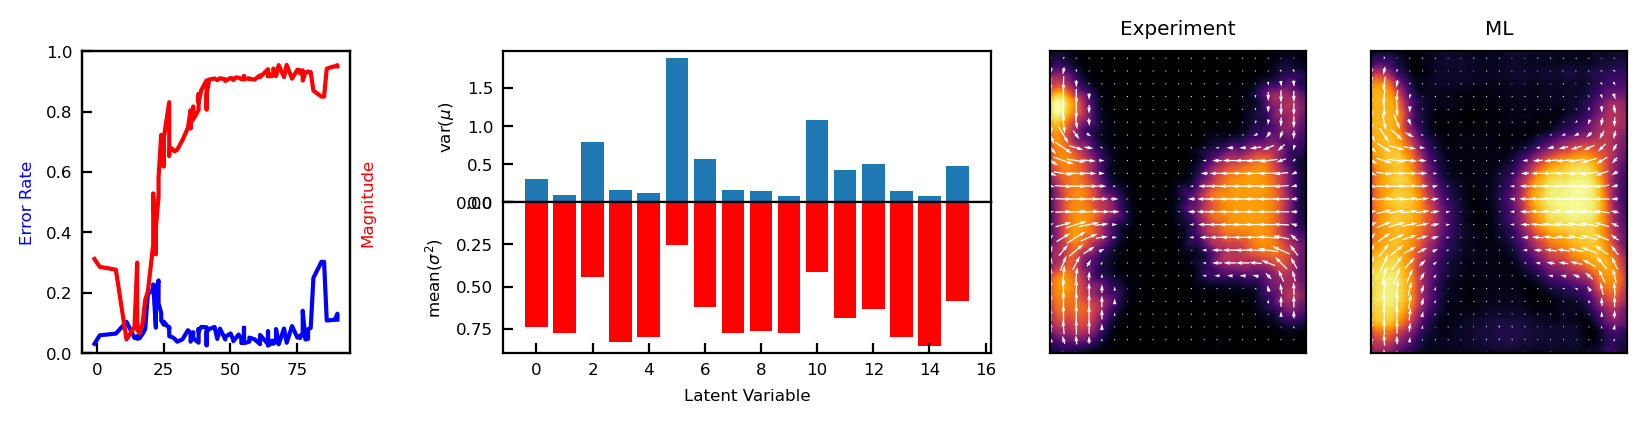

In [49]:
from plot_utils import *

def residual(u, v):
    umag = np.linalg.norm(u, axis=-3)                                                 
    vmag = np.linalg.norm(v, axis=-3)                                                 
                                                                                        
    uavg = np.sqrt((umag**2).mean(axis=(-2, -1), keepdims=True))                    
    vavg = np.sqrt((vmag**2).mean(axis=(-2, -1), keepdims=True))                    
                                                                                        
    res = uavg**2 * vmag**2 + vavg**2 * umag**2 - 2 * uavg * vavg * np.einsum('...ijk,...ijk->...jk', u, v)
    res /= 2 * vavg**2 * uavg**2                                                        
    return res 

def summary_plot(params, logvars, y, y0, df, show_tt):
    param_id = np.arange(params.shape[-1])
    param_id = param_id[None].repeat(params.shape[0], axis=0)

    param_var = np.var(params, axis=0)
    var_mean = np.mean(np.exp(logvars), axis=0)

    fig = plt.figure(figsize=(10, 2), dpi=200)
    gs = fig.add_gridspec(2, 5)
    
    ax = fig.add_subplot(gs[:, 0])
    res = residual(y, y0).mean(axis=(-2, -1))
    time = df.time.values
    order = np.argsort(time)
    ax.plot(time[order], res[order], color='blue')
    ax.set_ylabel('Error Rate', color='blue')
    ax.set(ylim=[0, 1])
    
    v = np.linalg.norm(y, axis=1).mean(axis=(-2, -1))
    ax2 = ax.twinx()
    ax2.plot(time[order], v[order], color='red')
    ax2.set_ylabel('Magnitude', color='red')
    ax2.set_yticks([])

    ax1 = fig.add_subplot(gs[0, 1:3])
    ax1.bar(
        param_id[0],
        param_var)
    ax1.set_ylabel('var($\mu$)')
    ax1.set(xticks=[], xlabel=[])
    
    ax2 = fig.add_subplot(gs[1, 1:3])
    ax2.bar(
        param_id[0],
        var_mean,
        color='red'
    )
    ax2.invert_yaxis()
    ax2.set_ylabel('mean($\sigma^2$)')
    ax2.set_xlabel('Latent Variable')
    
    fig.subplots_adjust(hspace=0.)
    offset = 0.05
    bb1 = ax1.get_position()
    bb1.x0 = bb1.x0 + offset
    ax1.set_position(bb1)
    bb2 = ax2.get_position()
    bb2.x0 = bb2.x0 + offset
    ax2.set_position(bb2)

    plt.rcParams['image.origin'] = 'lower'
    plt.rcParams['image.cmap'] = 'inferno'
    plot_fn(fig.add_subplot(gs[:, -2]), y0[show_tt])
    plt.title('Experiment')
    plot_fn(fig.add_subplot(gs[:, -1]), y[show_tt])
    plt.title('ML')
    
plt.rcParams['font.size'] = 6
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plot_fn = plot_vector2D
params = np.concatenate([results['params_train'], results['params_test']])
logvars = np.concatenate([results['logvars_train'], results['logvars_test']])
summary_plot(params, logvars, results['y_test'], results['y0_test'], results['test_df'], 0)

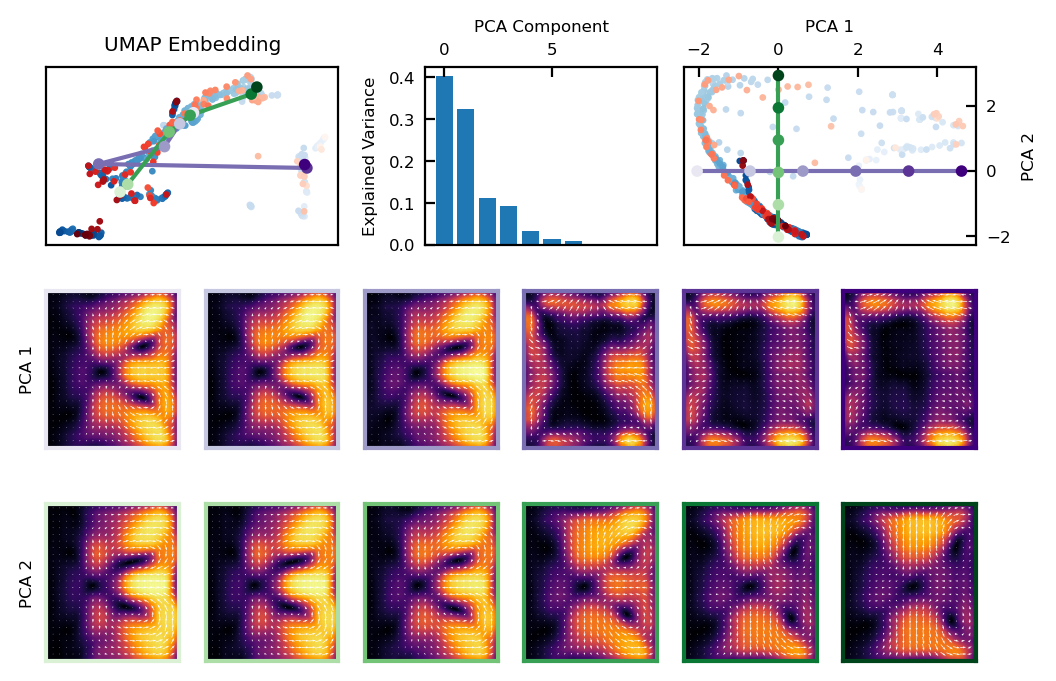

In [55]:
import torch.nn.functional as F
from plot_utils import *
import umap
from sklearn.decomposition import PCA

def reconstruct_nn(z):
    with torch.no_grad():
        z = torch.cuda.FloatTensor(z)
        z = model.params_to_field(z)
        z = F.gelu(z)
        z = z.reshape([z.shape[0], -1, *model.bottleneck_size])
        z = model.decoder(z)
        z = F.interpolate(z, size=[236, 200], mode='bilinear')
        z = z.cpu().numpy()
    return z
    
def sweep_points(reconstruct, pca, U, pca_points, fig, gs, ax_pca, ax_umap, cmap, pca_axis):
    points = np.zeros([gs.ncols, pca.n_components])
    points[:, pca_axis] = np.linspace(0, 1, points.shape[0]) * np.ptp(pca_points[:, pca_axis]) + np.min(pca_points[:, pca_axis])
    points[:, (pca_axis+1)%2] = np.mean(pca_points[:, (pca_axis+1)%2])

    z = pca.inverse_transform(points)
    
    U_points = U.transform(z)
    
    z = reconstruct(z)

    colors = plt.get_cmap(cmap)(np.linspace(0, 1, points.shape[0]+1))[1:]    
    ax_pca.scatter(points[:, 0], points[:, 1], color=colors, s=10, zorder=10)
    ax_pca.plot(points[:, 0], points[:, 1], color=colors[len(colors)//2])
    ax_umap.scatter(U_points[:, 0], U_points[:, 1], color=colors, s=10, zorder=10)
    ax_umap.plot(U_points[:, 0], U_points[:, 1], color=colors[len(colors)//2])
    
    vmax = np.max(np.linalg.norm(z, axis=1))

    for i in range(len(colors)):
        a = fig.add_subplot(gs[pca_axis+1, i])
        plot_fn(a, z[i], vmax=vmax)
        for spine in a.spines.values():
            spine.set_edgecolor(colors[i])
            spine.set_linewidth(1.5)
        if i == 0:
            a.set_ylabel('PCA %d' % (pca_axis+1))

def umap_pca_plot(train, test, train_df, test_df, reconstruct):
    U = umap.UMAP()
    umap_train = U.fit_transform(train)
    umap_test = U.transform(test)
    
    n_components=10
    pca = PCA(n_components=n_components)
    pca_train = pca.fit_transform(train)
    pca_test = pca.transform(test)

    fig = plt.figure(figsize=(6, 4), dpi=200)
    gs = fig.add_gridspec(3, 6)
    
    ax = fig.add_subplot(gs[0, 2:4])
    ax.bar(np.arange(n_components), pca.explained_variance_ratio_)
    ax.set(xlabel='PCA Component', ylabel='Explained Variance')
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    bb = ax.get_position()
    bb.x0 = bb.x0 + 0.05
    ax.set_position(bb)
    
    ax_umap = fig.add_subplot(gs[0, :2])
    ax_umap.scatter(umap_train[:, 0], umap_train[:, 1], c=train_df.time.values, cmap='Blues', s=2)
    ax_umap.scatter(umap_test[:, 0], umap_test[:, 1], c=test_df.time.values, cmap='Reds', s=2)
    ax_umap.set(title='UMAP Embedding', xticks=[], yticks=[])

    ax_pca = fig.add_subplot(gs[0, 4:6])
    ax_pca.scatter(pca_train[:, 0], pca_train[:, 1], c=train_df.time.values, cmap='Blues', s=2)
    ax_pca.scatter(pca_test[:, 0], pca_test[:, 1], c=test_df.time.values, cmap='Reds', s=2)
    ax_pca.set(xlabel='PCA 1', ylabel='PCA 2')
    ax_pca.yaxis.set_label_position("right")
    ax_pca.yaxis.tick_right()
    ax_pca.xaxis.set_label_position("top")
    ax_pca.xaxis.tick_top()
    args = (reconstruct, pca, U, pca_train, fig, gs, ax_pca, ax_umap)
    sweep_points(*args, pca_axis=0, cmap='Purples')
    sweep_points(*args, pca_axis=1, cmap='Greens')

plot_fn = plot_vector2D
umap_pca_plot(results['params_train'], results['params_test'], results['train_df'], results['test_df'], reconstruct_nn)

## Myosin field

100%|██████████| 21/21 [00:00<00:00, 661.11it/s]


{'lr': 0.0001, 'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 0.0, 'in_channels': 4, 'out_channels': 4, 'input': 'sqh', 'output': 'sqh', 'beta': 0.001}


100%|██████████| 6/6 [00:00<00:00, 13.94it/s]


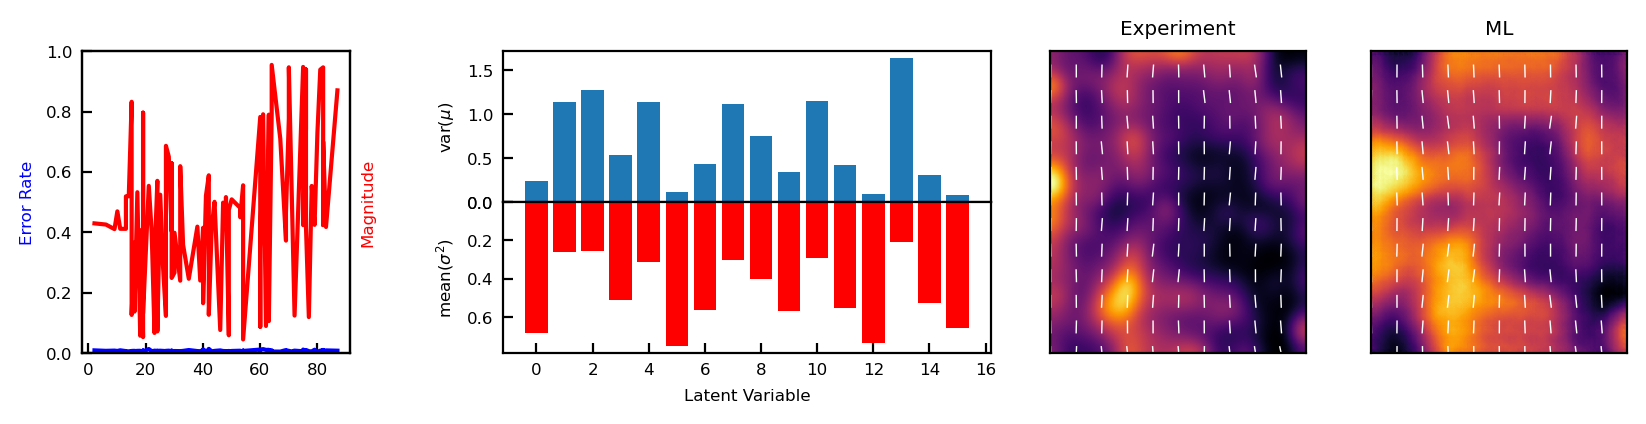

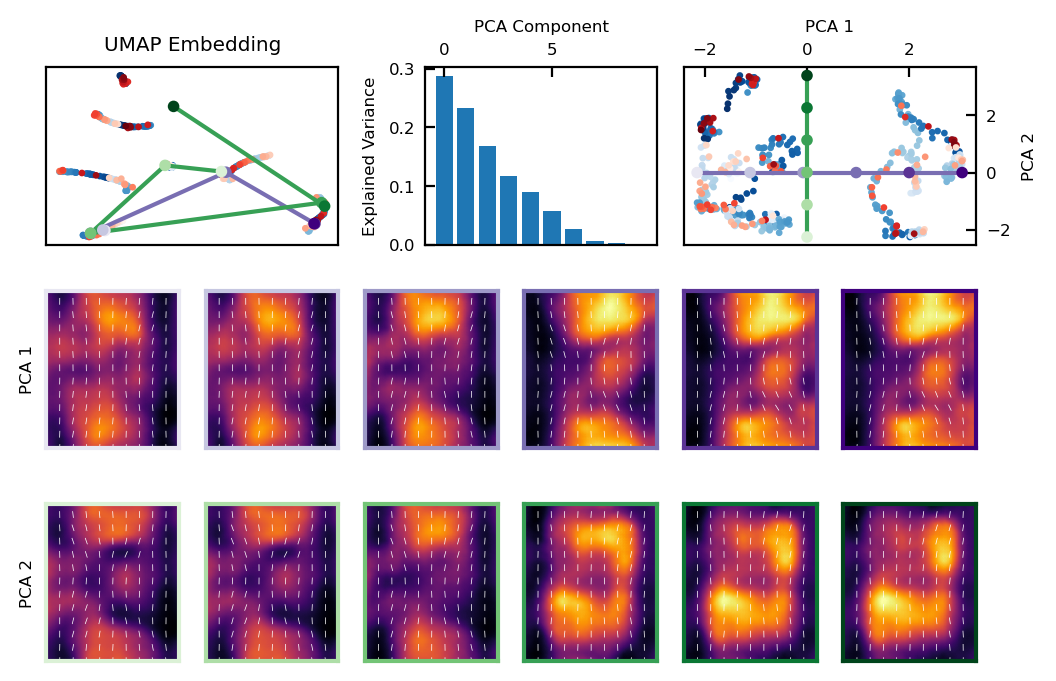

In [47]:
beta=1e-3
output = 'sqh'

checkpoint = torch.load(
    os.path.join(tb_logs,'Adam_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))

vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)

dataset = AlignedDataset([vel, sqh], ['vel', 'sqh'])
model, results = get_results(dataset, checkpoint)

plot_fn = plot_tensor2D
params = np.concatenate([results['params_train'], results['params_test']])
logvars = np.concatenate([results['logvars_train'], results['logvars_test']])
summary_plot(params, logvars, results['y_test'], results['y0_test'], results['test_df'], 0)
umap_pca_plot(results['params_train'], results['params_test'], results['train_df'], results['test_df'], reconstruct_nn)

100%|██████████| 6/6 [00:00<00:00, 641.41it/s]


{'lr': 0.0001, 'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 0.0, 'in_channels': 4, 'out_channels': 4, 'input': 'cad', 'output': 'cad', 'beta': 0.001}


100%|██████████| 6/6 [00:00<00:00, 13.75it/s]


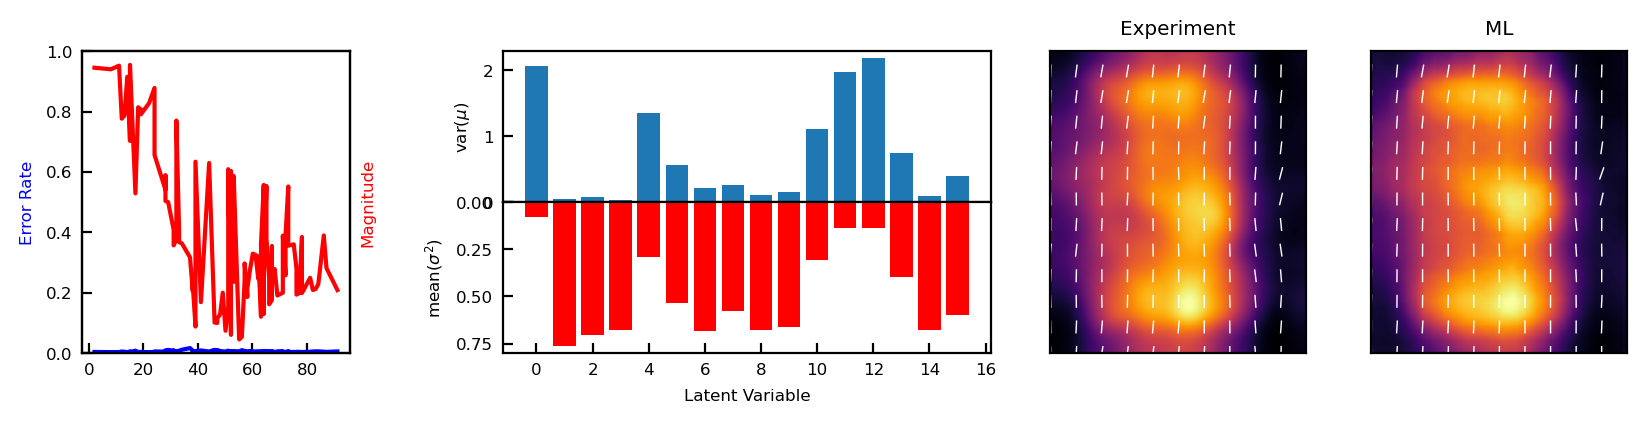

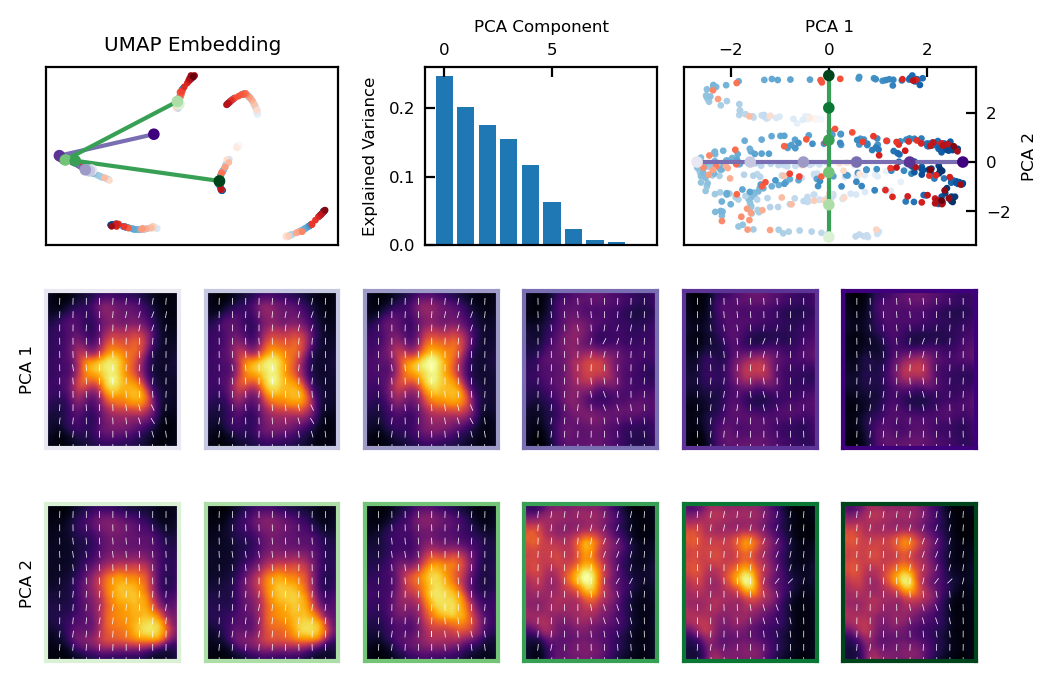

In [40]:
beta=1e-3
output = 'cad'

checkpoint = torch.load(
    os.path.join(tb_logs,'Adam_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))

vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
cad = AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform)

dataset = AlignedDataset([vel, cad], ['vel', 'cad'])
model, results = get_results(dataset, checkpoint)

plot_fn = plot_tensor2D
params = np.concatenate([results['params_train'], results['params_test']])
logvars = np.concatenate([results['logvars_train'], results['logvars_test']])
summary_plot(params, logvars, results['y_test'], results['y0_test'], results['test_df'], 0)
umap_pca_plot(results['params_train'], results['params_test'], results['train_df'], results['test_df'], reconstruct_nn)

100%|██████████| 6/6 [00:00<00:00, 654.07it/s]


{'lr': 0.0001, 'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 0.0, 'in_channels': 1, 'out_channels': 1, 'input': 'runt', 'output': 'runt', 'beta': 1e-05}


100%|██████████| 7/7 [00:00<00:00, 19.46it/s]


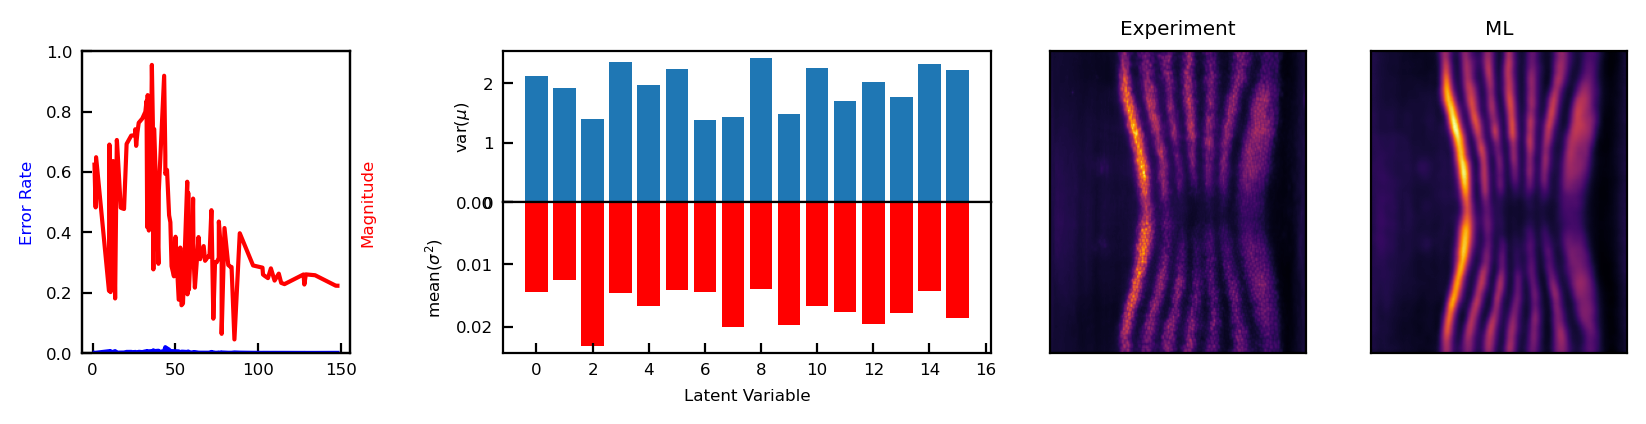

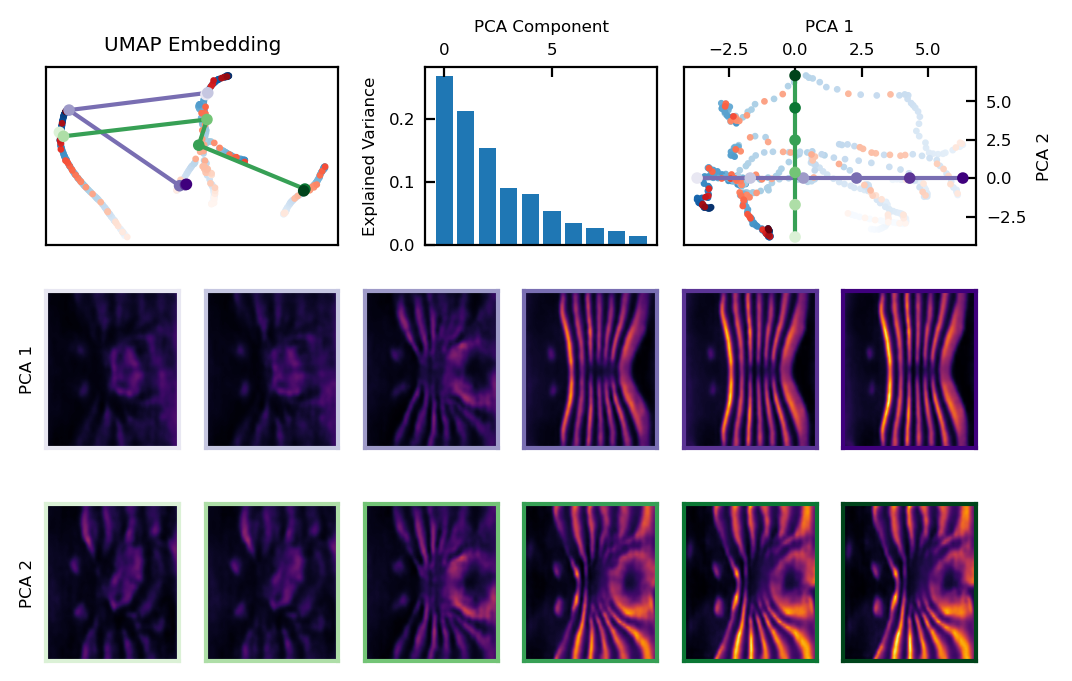

In [45]:
beta=1e-5
output = 'runt'

checkpoint = torch.load(
    os.path.join(tb_logs,'Adam_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))

vel = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)
runt = AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)

dataset = AlignedDataset([vel, runt], ['vel', 'runt'])
model, results = get_results(dataset, checkpoint)

from plot_utils import *
plot_fn = color_2D
params = np.concatenate([results['params_train'], results['params_test']])
logvars = np.concatenate([results['logvars_train'], results['logvars_test']])
summary_plot(params, logvars, results['y_test'], results['y0_test'], results['test_df'], 0)
umap_pca_plot(results['params_train'], results['params_test'], results['train_df'], results['test_df'], reconstruct_nn)

# GDTUO Optimizer

## Flow field

100%|██████████| 6/6 [00:00<00:00, 615.21it/s]


{'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 1e-08, 'in_channels': 2, 'out_channels': 2, 'input': 'vel', 'output': 'vel', 'beta': 0.0001}


100%|██████████| 6/6 [00:00<00:00, 18.47it/s]


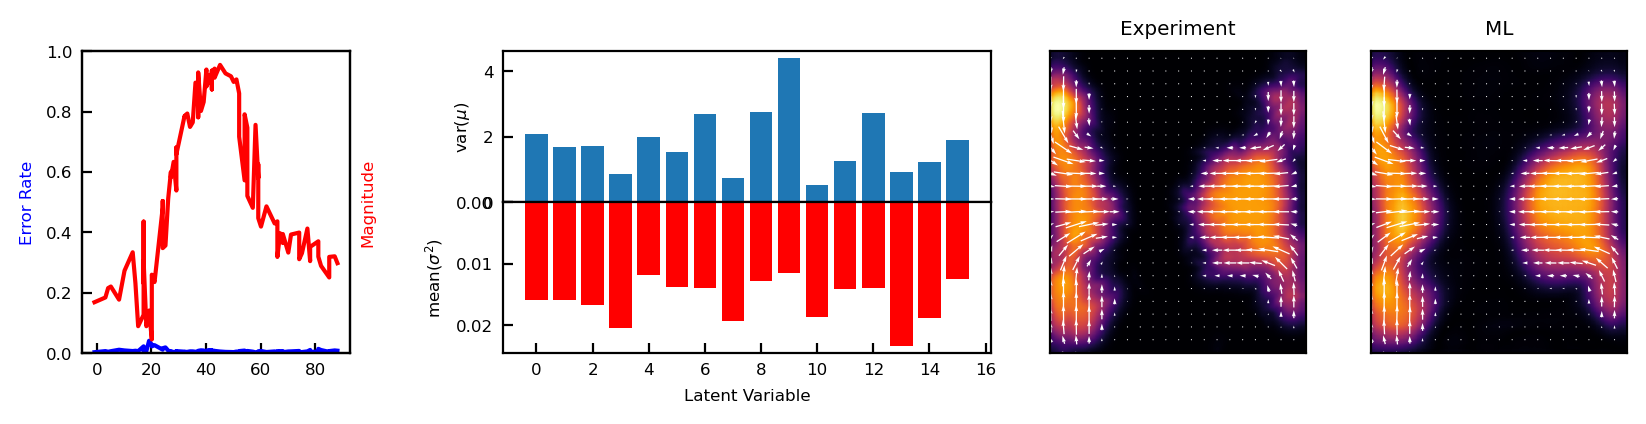

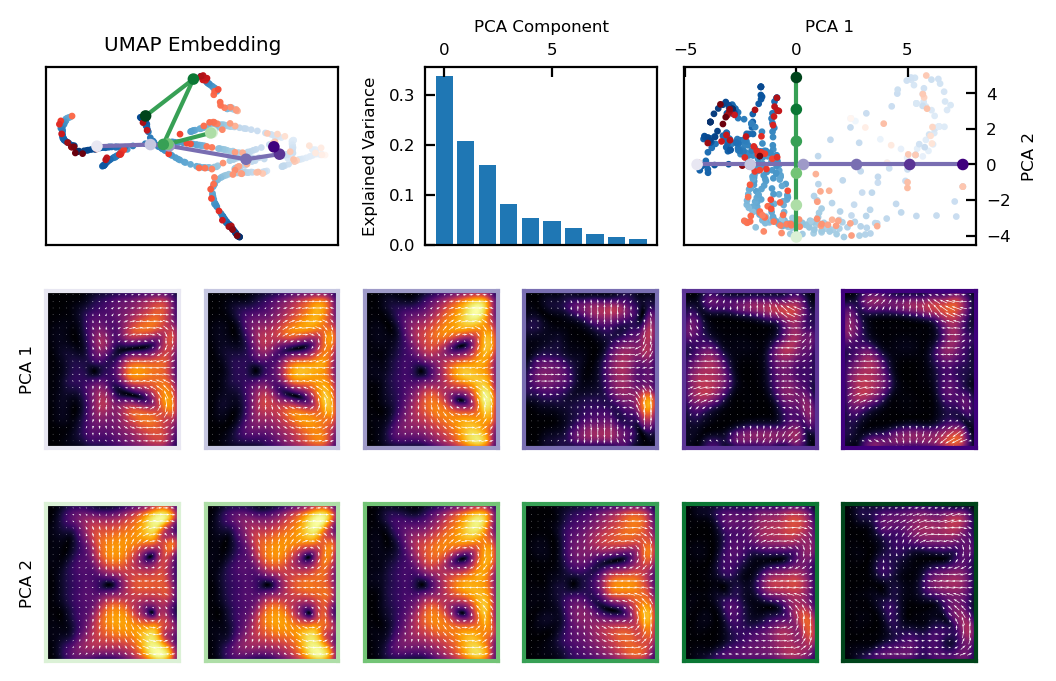

In [28]:
beta=1e-4
output = 'vel'

checkpoint = torch.load(
    os.path.join(tb_logs,'GDTUO_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))
vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
dataset = AlignedDataset([vel], ['vel'])

model, results = get_results(dataset, checkpoint)

plot_fn = plot_vector2D
params = np.concatenate([results['params_train'], results['params_test']])
logvars = np.concatenate([results['logvars_train'], results['logvars_test']])
summary_plot(params, logvars, results['y_test'], results['y0_test'], results['test_df'], 0)
umap_pca_plot(results['params_train'], results['params_test'], results['train_df'], results['test_df'], reconstruct_nn)